# Exploratory Data Analysis

In this notebook, we'll explore the relationships (if they exist) amongst the Zika virus data and the precipitation data across Argentina.

## Import libraries

We'll begin by importing all the necessary libraries. This includes `pandas` to work with csv files and data frames, `matplotlib` to draw plots and `geopandas` to work with geographical data. We'll also import necessary additional libraries (`descartes` and `Point`) to make everything work together.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import descartes
import geopandas as gpd
from shapely.geometry import Point

## Load datasets

We'll load in the data for coordinates for various provinces in Argentina via a file `places.csv`. Then, we'll import the Zika and precipitation monthly files.

In [2]:
# Location information
places = pd.read_csv("zika_data/places.csv")

# April, 2016 Zika data
zika_data = pd.read_csv("zika_data/2016-04.csv")
# April, 2016 Precipitation information
precipitation_data = pd.read_csv("data/precipitation_4_2016.csv")

## Universal functions

Here, we define a set of functions that can be used for any month and handle both the Zika and the precipitation datasets.

### Function: get_zika_coordinates

This function returns the list of all provinces of Argentina, with their coordinates and the number of Zika cases for that given month.

In [3]:
def get_zika_coordinates(data, places):
    """
    The function combines the Zika data with coordinates of 
    its respective province and then returns the aggregated 
    data for each province.
    """
    
    data_updated = pd.merge(data, 
                            places, 
                            how = 'inner', 
                            left_on = "location", 
                            right_on = "location")
    
    data_updated = data_updated[["location", "value", "latitude", "longitude"]] \
                                .groupby(["location", "latitude", "longitude"]) \
                                .sum().reset_index()

    data_updated["location"] = data_updated["location"] \
                                            .apply(lambda x: x.split("-")[1] \
                                                   .replace("_", " "))
    
    return data_updated

## Defining and formulating data

We'll define constants and set the data up.

In [4]:
zika_data = get_zika_coordinates(zika_data, places)

## Plot Zika data on Argentina

We'll plot the Zika cases of various provinces on the map of Argentina as markers where size of each marker is proportional to the number of Zika cases.

(-74.57707901000971,
 -52.592537689208925,
 -56.725680255889834,
 -20.114398097991888)

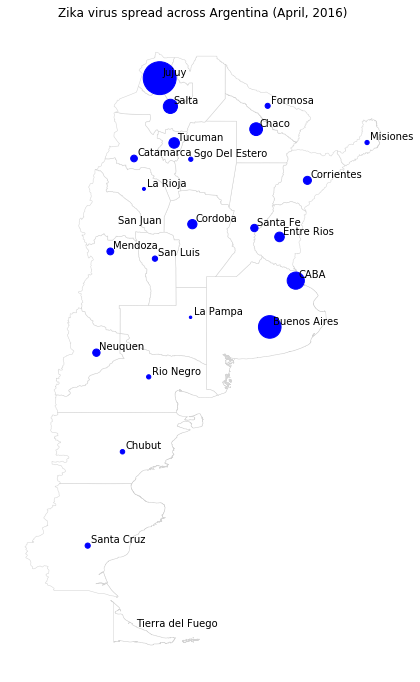

In [5]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
ax = world.plot(color = 'white', 
                linewidth = 0.5, 
                edgecolor = 'lightgrey', 
                figsize = (20, 12))

points = [Point(xy) for xy in zip(zika_data["longitude"], zika_data["latitude"])]
zika_df = gpd.GeoDataFrame(zika_data, crs = {'init': 'epsg:4326'}, geometry = points)

zika_df.plot(color = 'blue', ax = ax, markersize = 'value')
plt.title("Zika virus spread across Argentina (April, 2016)")
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext=(3, 3), textcoords="offset points")
ax.axis('off')

## Choropleth map of Zika Virus

A better representation for Zika Virus spread would be a choropleth plot across its provinces.

In [6]:
map_df = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,12,ARG,Argentina,1,Buenos Aires,AR.BA,0,None,Provincia,Province,None,Baires|Buenos Ayres,"MULTIPOLYGON (((-62.79792 -41.02708, -62.79863..."
1,12,ARG,Argentina,2,Córdoba,AR.CB,0,None,Provincia,Province,None,Cordova,"POLYGON ((-63.91583 -29.61752, -63.89259 -29.6..."
2,12,ARG,Argentina,3,Catamarca,AR.CT,0,None,Provincia,Province,None,None,"POLYGON ((-67.56227 -25.26014, -67.55945 -25.2..."
3,12,ARG,Argentina,4,Chaco,AR.CC,0,None,Provincia,Province,None,El Chaco|Presidente Juan Peron,"POLYGON ((-62.32162 -24.10896, -62.32147 -24.1..."
4,12,ARG,Argentina,5,Chubut,AR.CH,0,None,Provincia,Province,None,None,"MULTIPOLYGON (((-66.99986 -46.00014, -67.00014..."


The data reveals that the name of the provinces do not match with the Zika virus data and thus, first need to rename the provinces before we merge the two datasets for a beautiful choropleth plot.

In [7]:
location_mapper = {"CABA": "Ciudad de Buenos Aires", 
                   "Cordoba": "Córdoba", 
                   "Entre Rios": "Entre Ríos", 
                   "Neuquen": "Neuquén", 
                   "Rio Negro": "Río Negro", 
                   "Sgo Del Estero": "Santiago del Estero", 
                   "Tucuman": "Tucumán"}

zika_data["location"] = zika_data["location"] \
                        .apply(lambda x: location_mapper[x] 
                               if (x) in location_mapper.keys() 
                               else x )

(-74.57707901000971,
 -52.592537689208925,
 -56.725680255889834,
 -20.114398097991888)

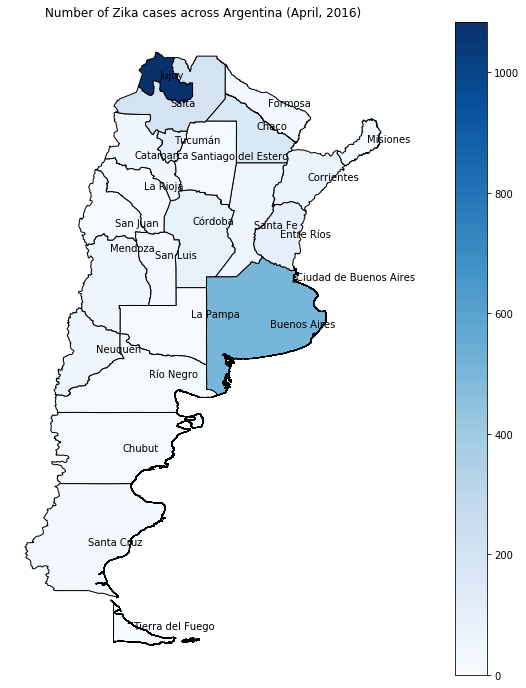

In [8]:
merged = map_df.merge(zika_data[["location", "value"]], left_on = "NAME_1", right_on = "location")

ax = merged.plot(column = 'value', cmap = "Blues", legend = True, figsize = (20, 12), edgecolor = 'black')
plt.title("Number of Zika cases across Argentina (April, 2016)")
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
ax.axis("off")

From the plot above, we infer that Jujuy had the maximum number of Zika cases, followed by Buenos Aires in April, 2019.

## Precipitation spread

Let's plot the peripitation distribution across Argentina. Here, we'll be working with April, 2016 data.

(-74.57737693511623,
 -52.592523502299095,
 -56.743037316433366,
 -20.11357157129934)

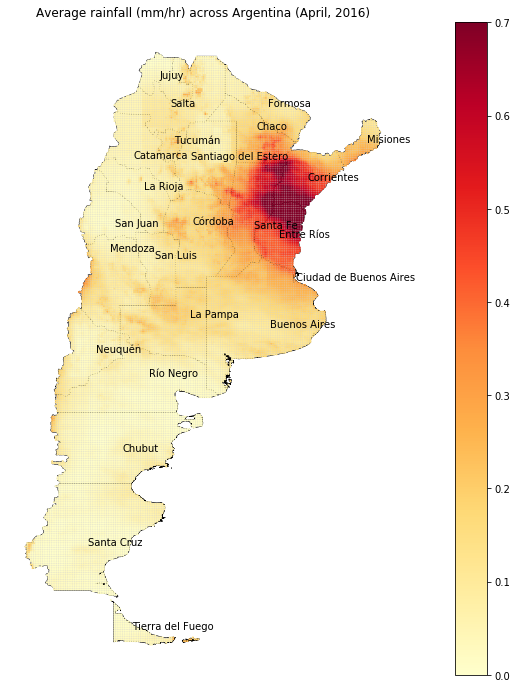

In [9]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
ax = world.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize = (20, 12))

points = [Point(xy) for xy in zip(precipitation_data["longitude"], precipitation_data["latitude"])]
geo_df = gpd.GeoDataFrame(precipitation_data, crs = {'init': 'epsg:4326'}, geometry = points)

geo_df.plot(column = 'precipitation', 
            markersize = 1, 
            ax = ax, 
            legend = True, 
            cmap = 'YlOrRd', 
            vmin = 0.0, 
            vmax = 0.7)
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
    
plt.title("Average rainfall (mm/hr) across Argentina (April, 2016)")
ax.axis('off')

The plot above reveals that in April, 2016, `Entre Rios`, `Santa Fe` and `Corrientes` received the maximum rainfall.

#### Key observation

Considering the geo plots for Zika spread and rainfall, we observe that the province for maximum Zika cases (Jujuy) does not align with the province with maximum rainfall (Entre Rios) for April, 2016 indicating that a direct correlation between rainfall and Zika spread might not exist.

## Zika and Rainfall overlay map

In this map, we'll plot the Zika cases as marker points on the rainfall data.

### April 2016

(-74.57737693511623,
 -52.592523502299095,
 -56.743037316433366,
 -20.11357157129934)

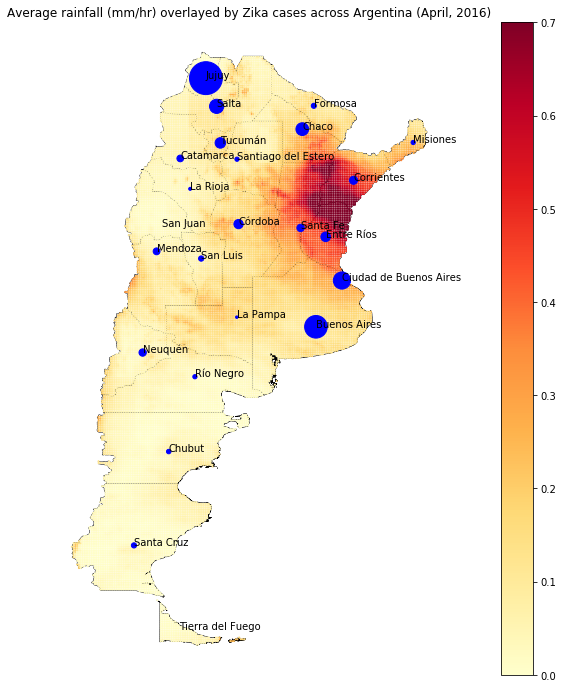

In [10]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")

ax = world.plot(color = 'white', linewidth = 0.5, edgecolor = 'black', figsize = (20, 12))

points = [Point(xy) for xy in zip(precipitation_data["longitude"], precipitation_data["latitude"])]
geo_df = gpd.GeoDataFrame(precipitation_data, crs = {'init': 'epsg:4326'}, geometry = points)
points2 = [Point(xy) for xy in zip(zika_data["longitude"], zika_data["latitude"])]
zika_df = gpd.GeoDataFrame(zika_data, crs = {'init': 'epsg:4326'}, geometry = points2)

geo_df.plot(column = 'precipitation', 
            markersize = 1, 
            ax = ax, 
            legend = True, 
            cmap = 'YlOrRd', 
            vmin = 0.0, 
            vmax = 0.7)
zika_df.plot(color = 'blue', ax = ax, markersize = 'value')

for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
    
plt.title("Average rainfall (mm/hr) overlayed by Zika cases across Argentina (April, 2016)")

ax.axis('off')

### September 2016

(-74.57737693511623,
 -52.592523502299095,
 -56.743037316433366,
 -20.11357157129934)

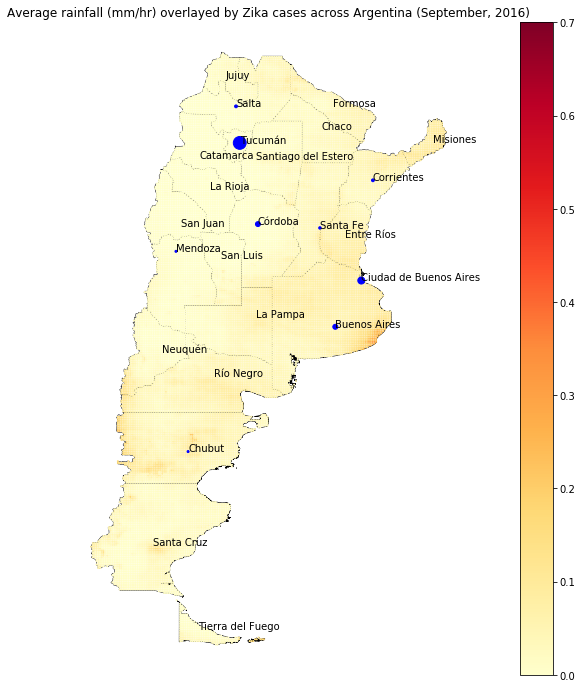

In [11]:
# September, 2016 Zika data
zika_data_sept_2016 = pd.read_csv("zika_data/2016-09.csv")
# September, 2016 Precipitation information
precipitation_data_sept_2016 = pd.read_csv("data/precipitation_9_2016.csv")

world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")

ax = world.plot(color = 'white', linewidth = 0.5, edgecolor = 'black', figsize = (20, 12))

zika_data_sept_2016 = pd.merge(zika_data_sept_2016, places, how = 'inner', left_on = "location", right_on = "location")
zika_data_sept_2016 = zika_data_sept_2016[["location", "value", "latitude", "longitude"]].groupby(["location", "latitude", "longitude"]).sum().reset_index()

points = [Point(xy) for xy in zip(precipitation_data_sept_2016["longitude"], precipitation_data_sept_2016["latitude"])]
geo_df = gpd.GeoDataFrame(precipitation_data_sept_2016, crs = {'init': 'epsg:4326'}, geometry = points)
points2 = [Point(xy) for xy in zip(zika_data_sept_2016["longitude"], zika_data_sept_2016["latitude"])]
zika_df = gpd.GeoDataFrame(zika_data_sept_2016, crs = {'init': 'epsg:4326'}, geometry = points2)

geo_df.plot(column = 'precipitation', 
            markersize = 1, 
            ax = ax, 
            legend = True, 
            cmap = 'YlOrRd', 
            vmin = 0.0, 
            vmax = 0.7)
zika_df.plot(color = 'blue', ax = ax, markersize = 'value')

for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
    
plt.title("Average rainfall (mm/hr) overlayed by Zika cases across Argentina (September, 2016)")

ax.axis('off')

## Time plots for Rainfall and Zika spread

Next, let's plot the distribution of rainfall and Zika cases from March, 2016 to June, 2017 and see if any correlation exists.

### Preparing the rainfall data

In [12]:
complete_precipitation_data = pd.read_csv("data/combined_data.csv")
complete_precipitation_data = complete_precipitation_data.groupby(["year", "month"]).sum().reset_index()
complete_precipitation_data["date"] = complete_precipitation_data["month"].map(str) + \
                                        "-" + \
                                        complete_precipitation_data["year"].map(str)
complete_precipitation_data["date"] = pd.to_datetime(complete_precipitation_data["date"], format = "%m-%Y")
complete_precipitation_data = complete_precipitation_data.iloc[2:-6,]

### Preparing the Zika data

In [13]:
combined_zika_data = pd.DataFrame(columns = ["location", "value", "year", "month"])

for month in ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
    dataset = pd.read_csv("zika_data/2016-" + month + ".csv")
    temp_df = dataset[["location", "value"]].groupby("location").sum().reset_index()
    temp_df["year"] = "2016"
    temp_df["month"] = int(month)
    combined_zika_data = combined_zika_data.append(temp_df, sort = True)
    
for month in ['01', '02', '03', '04', '05', '06']:
    dataset = pd.read_csv("zika_data/2017-" + month + ".csv")
    temp_df = dataset[["location", "value"]].groupby("location").sum().reset_index()
    temp_df["year"] = "2017"
    temp_df["month"] = int(month)
    combined_zika_data = combined_zika_data.append(temp_df, sort = True)

In [14]:
combined_zika_data["date"] = combined_zika_data["month"].map(str) + \
                                        "-" + \
                                        combined_zika_data["year"].map(str)
combined_zika_data["date"] = pd.to_datetime(combined_zika_data["date"], format = "%m-%Y")
combined_zika_data = combined_zika_data.groupby("date").sum().reset_index()

### Plotting the data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rainfall across Argentina from March, 2016 to April, 2017')

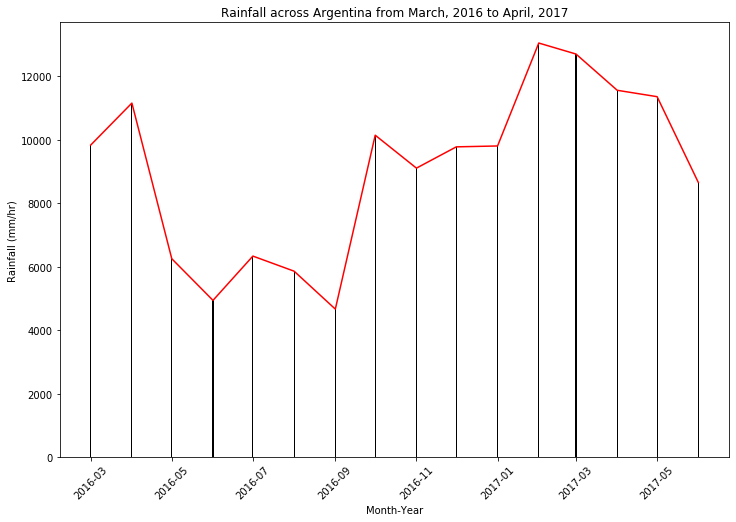

In [15]:
plt.figure(figsize = (12, 8))
plt.bar(complete_precipitation_data["date"], complete_precipitation_data["precipitation"], color = 'black')
plt.plot(complete_precipitation_data["date"], complete_precipitation_data["precipitation"], color = 'red')
plt.xticks(rotation = 45)
plt.ylabel("Rainfall (mm/hr)")
plt.xlabel("Month-Year")
plt.title("Rainfall across Argentina from March, 2016 to April, 2017")

Text(0.5, 1.0, 'Zika spread across Argentina from March, 2016 to April, 2017')

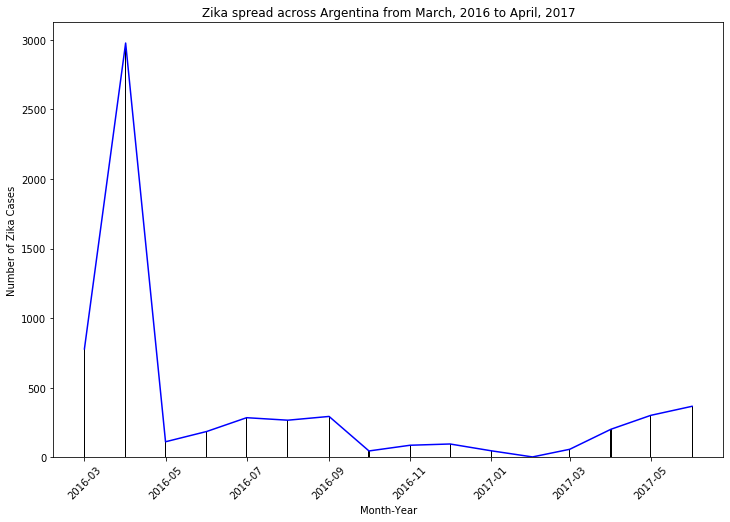

In [16]:
plt.figure(figsize = (12, 8))
plt.bar(combined_zika_data["date"], combined_zika_data["value"], color = 'black')
plt.plot(combined_zika_data["date"], combined_zika_data["value"], color = 'blue')
plt.xticks(rotation = 45)
plt.ylabel("Number of Zika Cases")
plt.xlabel("Month-Year")
plt.title("Zika spread across Argentina from March, 2016 to April, 2017")

#### Key observation

We notice that there is a spike in the number of Zika cases when there is high rainfall. However, such a trend is not consistent across the whole time series. As we can see, even when the rainfall increases by the end of 2016 right till March, 2017, there is no significant increase in the number of Zika cases.

## Province based Zika spread

Next, we'll explore how the Zika cases spread with respect to each province of Argentina.

In [17]:
combined_zika_data = pd.DataFrame(columns = ["location", "value", "year", "month"])

for month in ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
    dataset = pd.read_csv("zika_data/2016-" + month + ".csv")
    temp_df = dataset[["location", "value"]].groupby("location").sum().reset_index()
    temp_df["year"] = "2016"
    temp_df["month"] = int(month)
    combined_zika_data = combined_zika_data.append(temp_df, sort = True)
    
for month in ['01', '02', '03', '04', '05', '06']:
    dataset = pd.read_csv("zika_data/2017-" + month + ".csv")
    temp_df = dataset[["location", "value"]].groupby("location").sum().reset_index()
    temp_df["year"] = "2017"
    temp_df["month"] = int(month)
    combined_zika_data = combined_zika_data.append(temp_df, sort = True)

Text(0.5, 1.0, 'Number of Zika cases across various provinces in Argentina')

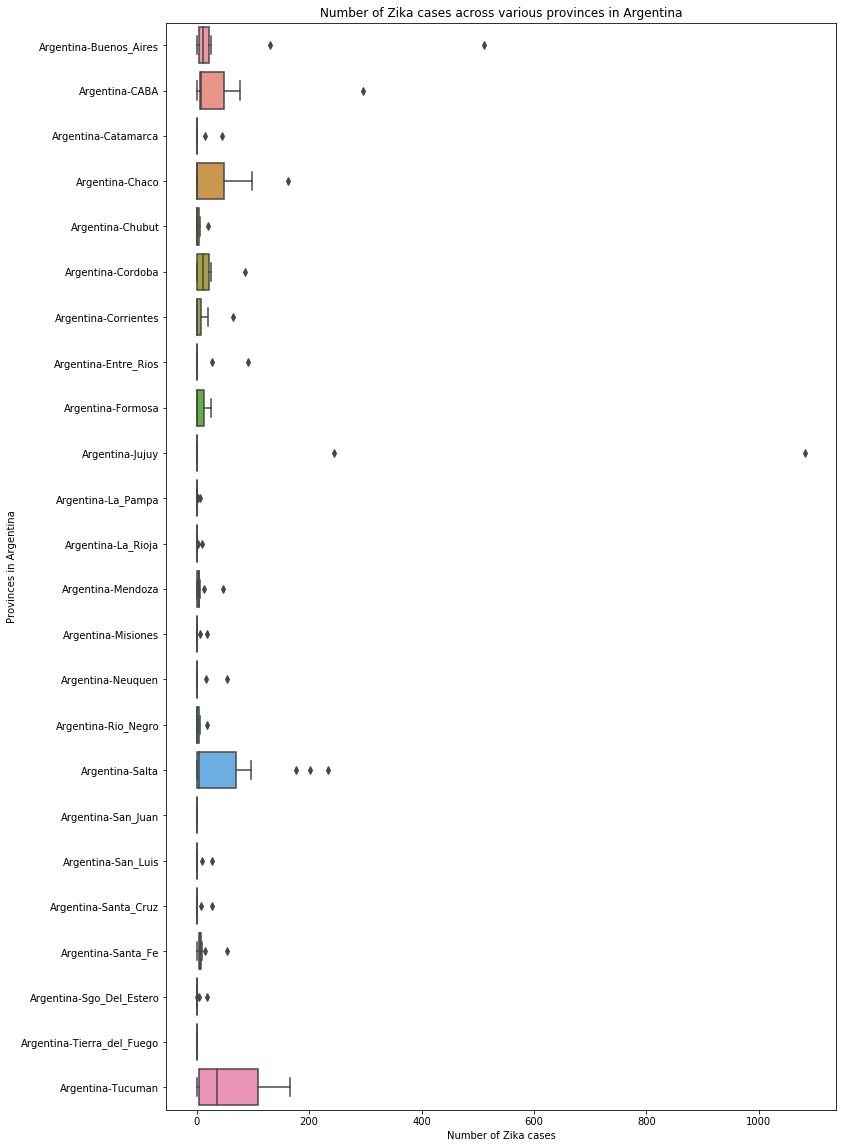

In [18]:
plt.figure(figsize = (12, 20))
sns.boxplot(x = "value", y = "location", data = combined_zika_data, orient = "h")
plt.xlabel("Number of Zika cases")
plt.ylabel("Provinces in Argentina")
plt.title("Number of Zika cases across various provinces in Argentina")